<a href="https://colab.research.google.com/github/harshitadd/Celestini/blob/master/Generalised_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install firebase-admin
import os 
import math
import cv2
import numpy as np 
import csv
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import warnings

In [0]:
'''

Preprocessing requirement : 
1. credentials.json 
2. UPDATED labels 
3. Match labels to their locations 
'''

In [0]:
warnings.simplefilter('ignore')

In [0]:
#Get Images from Firebase Storage
import datetime
import firebase_admin
from firebase_admin import credentials
from firebase_admin import storage

# Fetch the service account key JSON file contents
cred = credentials.Certificate("credentials.json")

# Initialize the app with a service account, granting admin privileges
app = firebase_admin.initialize_app(cred, {
    'storageBucket': 'fir-4ca2c.appspot.com',
}, name='storage')

In [0]:
def transmission(img, lt = 230, retMean = False):
  ker = np.ones((3, 3))/9.0
  imgrgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  b, g, r = cv2.split(img)
  hsv = cv2.cvtColor(imgrgb, cv2.COLOR_RGB2HSV)
  _, _, v = cv2.split(hsv)
  v_blur = cv2.filter2D(v, -1, ker)
  _,building_mask = cv2.threshold(v_blur, lt, 255, cv2.THRESH_BINARY)
  sky = cv2.bitwise_and(imgrgb, imgrgb, mask = building_mask)
  sky_mask = cv2.bitwise_not(building_mask, building_mask.copy())
  building = cv2.bitwise_and(imgrgb, imgrgb, mask = sky_mask)
 
  al = max(v_blur.flatten())
  #Airlight Found. Now calculate Transmission Map
  img_norm = img/float(al)
  b, g, r = cv2.split(img_norm)
  kernel = np.ones((3,3),np.uint8)
  im_new = np.zeros((img.shape[0], img.shape[1]))
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      im_new[i][j] = min(b[i][j], g[i][j], r[i][j])
  dcp = cv2.erode(im_new, kernel, iterations = 1)
  #ax[3].imshow(im_new, cmap = 'gray')
  #ax[4].imshow(dcp, cmap = 'gray')
  tr = np.ones((dcp.shape[0], dcp.shape[1]))
  for i in range(dcp.shape[0]):
    for j in range(dcp.shape[1]):
      tr[i][j] = 1 - dcp[i][j]
  #ax[1].imshow(tr, cmap = 'gray')
  if retMean == False:
    return tr
  elif retMean == True:
    return np.mean(tr)

In [0]:
def entropy(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  hist = cv2.calcHist( [image.astype('float32')],
              [0], 
              None,
               [256], 
              [0,256] )
  h_norm = 0
  h_norm = cv2.normalize(hist, h_norm)
  ent = 0
  for p in h_norm:
    try:
      ent += p*math.log(p, 2)
    except:
      pass
    
  return (-1 * ent[0])

In [0]:
def contrast(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  s = 0
  ss = 0
  mean = np.mean(image)
  x = (-1 * mean * (np.ones(image.shape)))
  ss = np.square(np.add(image, x))
  cont = np.sqrt(np.sum(ss)/float(image.size))
  return cont

In [8]:
#Loading E1 - Lenovo data : - sscb labels 
# until 14:43 - lenovo hold sscb photographs 
# 16:09 onwards - DTU Photographs 
data = []
reading = []
t = 0
bucket = storage.bucket(app=app)
blobs = bucket.list_blobs()

imglenovo = [] #has all the lenovo images by their name 
ctr=0
mits = set()
for blob in blobs:
  if blob.name[7:16]=="lenovoinS" :
    if int(blob.name[-8:-6])<19 and int(blob.name[-8:-6])>5:
      blob.download_to_filename('/content/' + "lenovo" + str(blob.name.split('/')[-1])+ '.jpeg')
      imglenovo.append("lenovo" + str(blob.name.split('/')[-1])+ '.jpeg') 
      #print("lenovo" + str(blob.name.split('/')[-1])+ '.jpeg')
      ctr+=1
      print(ctr)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [9]:
##Loading E2 - Mi data : 760 -- sscb labels 
# all SSCB photos 

bucket = storage.bucket(app=app)
blobs = bucket.list_blobs()

imgminote = [] #has all the minote pictures by their name 
ctr=0
mits = set()
for blob in blobs:
  if blob.name[7:16]=="minoteSSC" :
    if int(blob.name[-8:-6])<19 and int(blob.name[-8:-6])>5:
        print(blob.name)

        blob.download_to_filename('/content/' + "minote" + str(blob.name.split('/')[-1])+ '.jpeg')
        imgminote.append("minote" + str(blob.name.split('/')[-1])+ '.jpeg') 
        print("minote" + str(blob.name.split('/')[-1])+ '.jpeg')
        ctr+=1
        print(ctr)

images/minoteSSCB.JPG/2019-06-27 15:14:35
minote2019-06-27 15:14:35.jpeg
1
images/minoteSSCB.JPG/2019-06-27 15:15:34
minote2019-06-27 15:15:34.jpeg
2
images/minoteSSCB.JPG/2019-06-27 15:16:22
minote2019-06-27 15:16:22.jpeg
3
images/minoteSSCB.JPG/2019-06-27 15:16:40
minote2019-06-27 15:16:40.jpeg
4
images/minoteSSCB.JPG/2019-06-27 15:16:57
minote2019-06-27 15:16:57.jpeg
5
images/minoteSSCB.JPG/2019-06-27 15:19:21
minote2019-06-27 15:19:21.jpeg
6
images/minoteSSCB.JPG/2019-06-27 15:24:14
minote2019-06-27 15:24:14.jpeg
7
images/minoteSSCB.JPG/2019-06-27 16:42:56
minote2019-06-27 16:42:56.jpeg
8
images/minoteSSCB.JPG/2019-06-27 16:46:16
minote2019-06-27 16:46:16.jpeg
9
images/minoteSSCB.JPG/2019-06-27 16:49:53
minote2019-06-27 16:49:53.jpeg
10
images/minoteSSCB.JPG/2019-06-27 16:50:47
minote2019-06-27 16:50:47.jpeg
11
images/minoteSSCB.JPG/2019-06-27 16:51:15
minote2019-06-27 16:51:15.jpeg
12
images/minoteSSCB.JPG/2019-06-27 16:54:37
minote2019-06-27 16:54:37.jpeg
13
images/minoteSSCB.JPG

In [10]:
print(len(imgminote))   ##ends on 3rd july only sscb data 
print(len(imglenovo))   ##ends on 4th july 2:30 - sscb + DTU starts at 4:10  

826
667


In [0]:
k=0
im_trans=[]
im_ent=[]
im_cont=[]

for img in imgminote:
  im = cv2.imread(img)
  im = cv2.resize(im, (32,32))
  im_trans.append(np.ndarray.flatten(transmission(im, retMean = False)))
  im_ent.append(entropy(im))
  im_cont.append(contrast(im))
  k+=1
  

print(k)
print('IMGMINOTE PICTURES OVER')  



for img in imglenovo:
  im = cv2.imread(img)
  im = cv2.resize(im, (32,32))
  im_trans.append(np.ndarray.flatten(transmission(im, retMean = False)))
  im_ent.append(entropy(im))
  im_cont.append(contrast(im))
  k+=1
  

print(k)  
print('IMGLENOVOS PICTURES OVER')  
print(len(im_trans))



In [12]:
dict={}
num = len(imgminote)
print(num)


for i in range(0,num):
  l=[]
  l.append(im_trans[i])
  l.append(im_ent[i])
  l.append(im_cont[i])
  dict[(imgminote[i])]=l
  
  ##because the next values will be put in the same dict after this ending index 

826


In [14]:
ctr=0
for i in range(num,k):
  l=[]
  l.append(im_trans[i])
  l.append(im_ent[i])
  l.append(im_cont[i])
  dict[(imglenovo[ctr])]=l
  ctr+=1
  
  
print(ctr+num) ## so all have been traversed 
  

1493


In [15]:
print(len(dict))

1493


In [16]:
#Checking for outliers
ctr=0

#in entropy list 
for im in im_ent:
  if(im<20):
    print(im)
    ctr+=1
    
print(ctr)

#in contrast list 
ctr=0
for im in im_cont:
  if(im<20):
    print(im)
    ctr+=1
    
print(ctr)


5.428897857666016
5.230010032653809
5.240905284881592
5.268103122711182
5.268465042114258
5.130550861358643
15.443744659423828
7
2.7180139707272217
2.6006590961475515
2.5989893196006864
2.5575765436824045
2.5652071911152925
2.5652904668757026
6


In [0]:
k=0
#WRITE APPROPRIATE VALUES 
#just checking if all values have been appended properly 
for key in dict:
  k+=1
  if(k==603):
    print(key[:-5])
    print(dict[key])
  if(k==604):
    print(key[:-5])
    print(dict[key])
  if(k==1429):
    print(key)
    print(dict[key])
 

In [17]:
#converting all image timestamps into cpcb compatible timestamp 
tmp=[]
for key in dict:
  temp=key[-24:-5]
  temp=temp.split('-')
  
  newtemp=temp[2].split(' ')
  
  newesttemp=newtemp[1].split(':')
  j=int(newesttemp[1])
  #print(j)
  if(j<=7.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  elif(j<=15 or j<=22.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '15'
  elif(j<=30 or j<=37.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '30'
  elif(j<=45 or j<=52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '45'
  elif(j>52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  tmp.append(final)
  
  
print(tmp)

['27-06-2019 15:15', '27-06-2019 15:15', '27-06-2019 15:15', '27-06-2019 15:15', '27-06-2019 15:15', '27-06-2019 15:15', '27-06-2019 15:30', '27-06-2019 16:45', '27-06-2019 16:45', '27-06-2019 16:45', '27-06-2019 16:45', '27-06-2019 16:45', '27-06-2019 16:00', '27-06-2019 16:00', '27-06-2019 17:00', '27-06-2019 17:00', '27-06-2019 17:15', '27-06-2019 17:15', '27-06-2019 17:15', '27-06-2019 17:30', '27-06-2019 17:30', '27-06-2019 17:30', '27-06-2019 17:45', '27-06-2019 17:45', '27-06-2019 17:45', '27-06-2019 17:00', '27-06-2019 18:00', '27-06-2019 18:00', '27-06-2019 18:15', '27-06-2019 18:15', '27-06-2019 18:15', '27-06-2019 18:30', '27-06-2019 18:30', '27-06-2019 18:30', '27-06-2019 18:45', '27-06-2019 18:45', '27-06-2019 18:45', '27-06-2019 18:00', '27-06-2019 18:00', '28-06-2019 06:00', '28-06-2019 06:00', '28-06-2019 06:15', '28-06-2019 06:15', '28-06-2019 06:15', '28-06-2019 06:30', '28-06-2019 06:30', '28-06-2019 06:30', '28-06-2019 06:45', '28-06-2019 06:45', '28-06-2019 06:45',

In [18]:
i=0
#checking correlation between actual and generated timestamps 
for key in dict:
  print(key)
  print('\r' + tmp[i])
  i+=1

minote2019-06-27 15:14:35.jpeg
27-06-2019 15:15
minote2019-06-27 15:15:34.jpeg
27-06-2019 15:15
minote2019-06-27 15:16:22.jpeg
27-06-2019 15:15
minote2019-06-27 15:16:40.jpeg
27-06-2019 15:15
minote2019-06-27 15:16:57.jpeg
27-06-2019 15:15
minote2019-06-27 15:19:21.jpeg
27-06-2019 15:15
minote2019-06-27 15:24:14.jpeg
27-06-2019 15:30
minote2019-06-27 16:42:56.jpeg
27-06-2019 16:45
minote2019-06-27 16:46:16.jpeg
27-06-2019 16:45
minote2019-06-27 16:49:53.jpeg
27-06-2019 16:45
minote2019-06-27 16:50:47.jpeg
27-06-2019 16:45
minote2019-06-27 16:51:15.jpeg
27-06-2019 16:45
minote2019-06-27 16:54:37.jpeg
27-06-2019 16:00
minote2019-06-27 16:59:33.jpeg
27-06-2019 16:00
minote2019-06-27 17:04:38.jpeg
27-06-2019 17:00
minote2019-06-27 17:05:00.jpeg
27-06-2019 17:00
minote2019-06-27 17:09:17.jpeg
27-06-2019 17:15
minote2019-06-27 17:14:39.jpeg
27-06-2019 17:15
minote2019-06-27 17:19:17.jpeg
27-06-2019 17:15
minote2019-06-27 17:24:39.jpeg
27-06-2019 17:30
minote2019-06-27 17:29:17.jpeg
27-06-201

In [0]:
i=0
ecttime=[]
for key in dict:
  l=[]
  l.append(tmp[i])
  l.append(dict[key])
  ecttime.append(l)
  i+=1

##ecttime is the list with modified timestamp matched with e,c,t

In [22]:
print(len(ecttime))

1493


In [23]:
k=0
cpcb=[]
with open('/content/labels.csv') as file:
  reader = csv.reader(file, delimiter =',')
  for row in reader:
    k+=1
    if(k>=18):
      l=[]
      l.append(row[0])
      l.append(row[2])
      cpcb.append(l)      
  
  print(len(cpcb))


733


In [25]:
#Checking for missing values and removing those values 

ctr=0
for i in range(0,len(cpcb)-1):
  if(cpcb[i][1]=='None'):
    ctr+=1
    pre = float(cpcb[i-1][1])
    post = float(cpcb[i+1][1])
    if(pre ==np.nan):
      print(cpcb[i])
      pre == '0.0'
    if(post==np.nan):
      print(cpcb[i])
      post == '0.0'
    cpcb[i][1]=str((pre + post)/2)
    
    
    
print(ctr)

##checking the last element
if(cpcb[len(cpcb)-1][1]=='None'):
  cpcb[len(cpcb)-1][1]=='0.0'

# for i in range(0,len(cpcb)):
#   if(cpcb[i][1]=='na'):
#     print(cpcb[i])
#     cpcb[i][1]='0.0'
#   if(cpcb[i][1]=='NaN'):
#     print(cpcb[i])
#   if(cpcb[i][1]=='NAN'):
#     print(cpcb[i])
#     cpcb[i][1]='0.0'
  
  
  


0


In [0]:
final=[]
for e in ecttime:
  for tmp in cpcb:
    if(tmp[0] == e[0]):
      l=[]
      l.append(tmp[0])
      l.append(tmp[1])
      l.append(e[1])
      final.append(l)


In [27]:
print(len(final))

1477


In [0]:
for i in final:
  print(i)

In [0]:
#the entropy and contrast are drastically different - 6 pm 
print(final[0])
print(im_ent[0])

print(min(im_ent))
print(min(im_cont))
print(max(im_ent))
print(max(im_cont))

In [29]:
print(im_trans)

[array([0.88983051, 0.88983051, 0.88983051, ..., 0.89830508, 0.91525424,
       0.91525424]), array([0.73991031, 0.73991031, 0.73991031, ..., 0.9058296 , 0.9058296 ,
       0.9058296 ]), array([0.90049751, 0.90049751, 0.90049751, ..., 0.97014925, 0.97014925,
       0.97014925]), array([0.76190476, 0.76190476, 0.76190476, ..., 0.66666667, 0.66666667,
       0.66666667]), array([0.75, 0.75, 0.75, ..., 0.7 , 0.7 , 0.7 ]), array([0.89626556, 0.89626556, 0.85477178, ..., 0.88381743, 0.88381743,
       0.88381743]), array([0.75, 0.75, 0.85, ..., 0.65, 0.75, 0.75]), array([0.17209302, 0.17209302, 0.16744186, ..., 0.86511628, 0.8744186 ,
       0.8744186 ]), array([0.71428571, 0.71428571, 0.66666667, ..., 0.71428571, 0.71428571,
       0.71428571]), array([0.7, 0.7, 0.7, ..., 0.7, 0.7, 0.7]), array([0.76036866, 0.76036866, 0.76036866, ..., 0.87557604, 0.87557604,
       0.87557604]), array([0.18141593, 0.65486726, 0.7079646 , ..., 0.67699115, 0.69469027,
       0.69469027]), array([0.71428571,

In [0]:
#Feature engineering
hours=[]
trans=[]
cont=[]
ent=[]
pm=[]



for e in final:
  #print(e[0][-5:-3])
  hours.append(float(e[0][-5:-3]))
  pm.append(float(e[1]))
  #print(e[2][0])
  trans.append(e[2][0])
  ent.append(float(e[2][1]))
  cont.append(float(e[2][2]))


In [31]:
print(len(hours))
print(hours)
print(len(trans))
print(trans)
print(len(cont))
print(cont)
print(len(ent))
print(ent)
print(len(pm))
print(pm)

1477
[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 17.0, 17.0, 17.0,

In [35]:

final_shape=len(hours)

hours = np.reshape(hours,(final_shape,1))
# trans = np.reshape(trans,(final_shape,1))
cont = np.reshape(cont,(final_shape,1))
ent = np.reshape(ent,(final_shape,1))
pm = np.reshape(pm,(final_shape,1))

features = np.hstack((hours, cont, ent, trans))
print(features[0])
scaler = StandardScaler()

hours = scaler.fit_transform(hours)
trans = scaler.fit_transform(trans)
cont = scaler.fit_transform(cont)
ent = scaler.fit_transform(ent)


features = np.hstack((hours, cont, ent, trans))

print(features[0])


[ 0.75596228 -0.86510238  0.4864978  ...  0.55093767 -0.04823393
 -0.04043687]
[ 0.75596228 -0.86510238  0.4864978  ...  0.55093767 -0.04823393
 -0.04043687]


In [0]:
def learning_curve(model, X, y):
  x_train, x_test, y_train , y_test = train_test_split(features, pm, test_size = 0.3, random_state = 42 )
  val_error=[]
  train_error=[]
  for m in range(1, len(x_train)):
    reg.fit(x_train[:m], y_train[:m])
    test_pred = reg.predict(x_test)
    train_pred = reg.predict(x_train[:m])
    val_error.append(np.sqrt(mean_squared_error(test_pred, y_test)))
    train_error.append(np.sqrt(mean_squared_error(train_pred , y_train[:m])))
    

  plt.plot(val_error,"r-" ,label = 'Validation error')
  plt.plot(train_error,"b-" ,label = 'train error ')

45.28097513329838
31.736125727397265


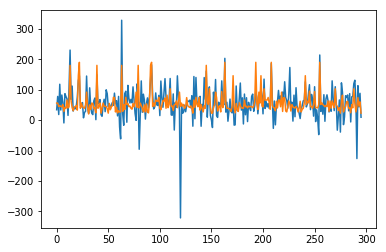

In [40]:
#Linear REGRESSOR 
reg = LinearRegression(normalize =True)

x_train, x_test, y_train, y_test = train_test_split(features, pm, test_size =0.2, random_state =42)

reg.fit(x_train, y_train)

pred = reg.predict(x_test)

plt.plot(pred)
plt.plot(y_test)

print(mean_squared_error(pred, y_test)**0.5)
print(mean_absolute_error(pred, y_test))




In [0]:
learning_curve(reg, features, pm)

In [42]:
shape = np.shape(pred)

pred = np.reshape(pred, shape)
y_test = np.reshape(y_test, shape)
result = np.hstack((pred, y_test))
print(result)


[[  34.13402683   56.        ]
 [  77.91310164   56.        ]
 [  18.44923734   44.5       ]
 [ 117.94995269   48.        ]
 [  33.28863193   45.        ]
 [  82.5656973    44.        ]
 [  57.95079428   51.        ]
 [  -9.13341457   28.6       ]
 [  86.99935657   42.31      ]
 [  77.68204118   39.        ]
 [  69.7695545    66.        ]
 [  15.61996045   40.        ]
 [ 106.14511689   44.        ]
 [ 230.18283493  180.        ]
 [  68.33710693   63.        ]
 [ 111.91572396   41.        ]
 [  29.96567987   30.8       ]
 [  41.32962122   42.5       ]
 [  37.13162939   45.        ]
 [  45.78855      47.        ]
 [  74.78512209   32.97      ]
 [ 129.36077264  146.        ]
 [ 145.81841392  190.        ]
 [  45.99009593   39.        ]
 [  43.68321305   56.        ]
 [  57.74325197   44.        ]
 [   7.68867559   41.        ]
 [  25.48573134   39.        ]
 [  28.93598557   51.        ]
 [ 144.86736594   92.        ]
 [  41.83796691   42.42      ]
 [  22.04905869   20.39      ]
 [ 106.1

In [43]:
print(max(np.diff(result)))
print(min(np.diff(result)))

[366.15103745]
[-148.18393864]


In [0]:
print(np.shape(features))
print(np.shape(pm))

print(type(hours))
print(type(cont))
print(type(ent))
print(type(trans))
print(type(pm))

In [0]:
reg = SGDRegressor()

features = np.hstack((hours, cont, ent, trans))

x_train, x_test, y_train, y_test = train_test_split(features, pm, test_size =0.2, random_state =42)
 

reg.fit(x_train,y_train)

pred = reg.predict(x_test)

plt.plot(pred)
plt.plot(y_test)

print(mean_squared_error(pred, y_test)**0.5)
print(mean_absolute_error(pred, y_test))

In [0]:
learning_curve(reg, features, pm)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


19.823223100699128
12.591736828794414


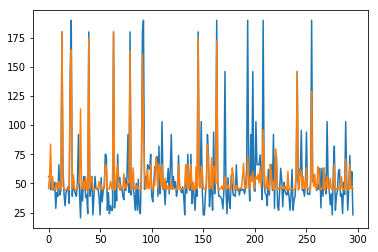

In [58]:
reg = RandomForestRegressor(max_depth=3)
reg.fit(x_train, y_train)
pred = reg.predict(x_test)


plt.plot(y_test)
plt.plot(pred)
print(mean_squared_error(pred, y_test)**0.5)
print(mean_absolute_error(pred, y_test))

In [0]:
learning_curve(reg, features, pm)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was pas

In [48]:
print(np.shape(pred))

(296,)


In [57]:
for i in range(0,296):
  print(str(y_test[i]) + '\t' + str(pred[i]))

56.0	3591975084.8359227
56.0	-2760014321.888539
44.5	-1808696764.3031263
48.0	6254466908.780124
45.0	-14789974628.93347
44.0	15453311315.531221
51.0	-5518707627.25595
28.6	-12180570980.723316
42.31	7328105470.217052
39.0	4947468546.647907
66.0	-240279491.37466726
40.0	3489233393.926221
44.0	7165376840.384047
180.0	2593469202.3133626
63.0	7555411094.8424425
41.0	-329110545.83014405
30.8	-17901643255.83504
42.5	7510966024.69755
45.0	1339929883.481183
47.0	735611006.6574835
32.97	2131575366.9739742
146.0	3273196869.4189615
190.0	-9477185633.24333
39.0	3757219518.753394
56.0	3869631057.6063075
44.0	-2945456869.782708
41.0	-4759091780.337332
39.0	-8428387746.828436
51.0	-4242122677.0369587
92.0	633922072.9349562
42.42	-2682978088.1775904
20.39	-7642197891.198098
50.0	11224585770.19146
35.0	3638553417.7817025
56.0	-7239597981.970619
55.0	11790667069.767357
38.0	826672335.2338455
40.0	3214943111.3970766
24.0	4802749103.786673
180.0	-11135018104.173822
39.0	2633523852.641587
45.0	-10354693989.

In [0]:
import json

with 